## Краткое описание 

В сфере услуг каждый сражается за ключевой показатель - лояльность пользователей в долгосрочной перспективе. Чем дольше клиент останется с нами, тем больше финансовой и маркетинговой пользы он принесет. Многие тратят огросне деньги на то, чтобы как можно точнее выявлять персепктивных и лояльных пользователей на ранеей стадии - а мы с вами научимся это делать абсолютно бесплатно, используя первые 3 визита клиента и доступные нам характеристики. 

Набор данных представляет из себя самые обычный отчет по продажам за 15 месяцев. По каждому клиенту есть следующие характиристики:  
•	 Дата визита   
•	 Id клиента   
•	 Наименование услги   
•	 Категория товара   
•	 Количество услуг за определенную покупку   
•	 Цена за определенную покупку   

Никакой дополнительной информации у нас нет и ,зачастую, при проектной работе с малым и средним бизнесом, у вас не будет широкого спектра данных о ваших пользователях - лишь то, что соберете в вашу CRM. 

## Цель 

Нам необходимо решить прикладную задачу продуктовой аналитики - по первым 3 визитам клиента определить, войдет ли пользователь в 20% лучших клиентов по сроку жизни (отметка в 20% взята из правила Парето). Далее можно проверить веротяность достижения определенных финансовых показателей или числа визитов, но сегодня мы будем работать именно с длительностью жизни новых клиентов. Сразу определим, что нам нужно как можно точнее определить клиентов, которые будут ходить к нам долго -> нужно добиться максимального recall для показателя (1) при высоком уровне f1-score

## Задачи

Совершенно естественно, что ответ никогда не лежит на поверхности и ,чтобы добраться до нужной нам информации, нужно решить промежуточные задачи, которые также дадут ответы на некоторые вопросы продуктовой области: 

•	 Когда считать нашего клиента потерянным?  
•	 Сколько живут ваши клиенты?  
•	 Как быстро обновляется наша клиентская база?   
•	 Какой Retantion у пользователей, которые пришли только один раз?  

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import scipy as sp
import warnings
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline

sns.set(rc={'figure.figsize':(12,8)})

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier as Classifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score



In [155]:
df = pd.read_csv("/Users/vazha/Downloads/Тестирование/клиенты_салона.csv")

In [156]:
df.head(5)

,datetime,Tovar,client,price,category,Kolichestvo
0,15.01.2021 13:06:33,Женская стрижка средние с укладкой,03533,2300,Укладка,1
1,15.01.2021 13:06:33,Дегустация цвета короткие,03533,6500,Окрашивание,1
2,15.01.2021 14:10:19,Женская стрижка средние с укладкой,00097,2300,Укладка,1
3,15.01.2021 14:10:19,Экспресс-уход Davines (маска в ассорт.),00097,650,Уход,1
4,15.01.2021 14:42:04,Укладка длинных волос,01906,2500,Укладка,1


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   datetime     4295 non-null   object
 1   Tovar        4295 non-null   object
 2   client       4286 non-null   object
 3   price        4295 non-null   int64 
 4   category     4295 non-null   object
 5   Kolichestvo  4295 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 201.5+ KB


In [158]:
df.select_dtypes(include=['object']).describe()

,datetime,Tovar,client,category
count,4295,4295,4286,4295
unique,2756,194,470,5
top,19.03.2021 18:53:26,Стрижка мужская,01523,Окрашивание
freq,8,679,214,1282


In [159]:
df.drop([4199,4200,4213,4214,4215],axis=0,inplace=True)

In [160]:
## Для перемнной с временем визта сделаем тип данных datetime64

df['datetime'] = pd.to_datetime(df['datetime'],format="%d.%m.%Y %H:%M:%S")

# В переменную Date положим конкретный день визита 

df['Date'] = df['datetime'].dt.date

count       470.000000
mean      26867.191489
std       47219.324516
min         150.000000
25%        2800.000000
50%        8475.000000
75%       29837.500000
max      515100.000000
Name: Total_sum, dtype: float64


<AxesSubplot:>

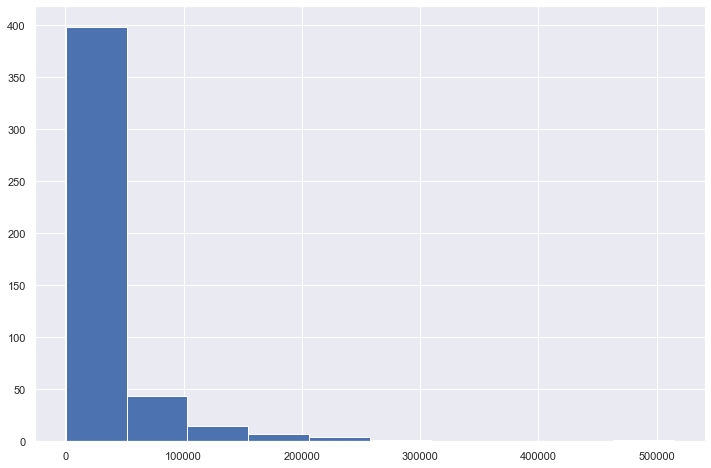

In [161]:
## Гистограмма распределения общей выручке по клиентам 

print(df.groupby('client').agg(Total_sum = ('price','sum'))['Total_sum'].describe())

df.groupby('client').agg(Total_sum = ('price','sum'))['Total_sum'].hist()

In [162]:
## Для каждогок леинта определеим первый и послежний визит 

client_table = df.groupby('client',as_index = False).agg(first_visit = ('Date','min'),
                                          last_visit = ('Date','max'))

client_table.head(10)

,client,first_visit,last_visit
0,00001,2021-04-07,2022-02-20
1,00002,2021-03-24,2022-02-12
2,00007,2021-01-15,2021-01-15
3,00015,2021-03-22,2021-11-30
4,00030,2021-02-12,2022-02-18
5,00048,2021-04-09,2021-04-09
6,00049,2022-02-27,2022-02-27
7,00062,2022-01-16,2022-01-16
8,00081,2021-02-02,2022-02-15
9,00090,2021-02-15,2022-03-26


In [163]:
## Рассчитаем срок жизни для каждого пользователя 

client_table['lifetime'] = (client_table['last_visit'] - client_table['first_visit']).dt.days

<AxesSubplot:>

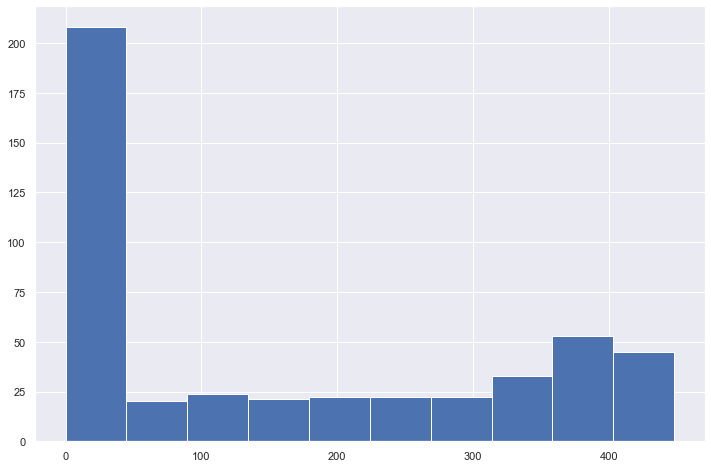

In [164]:
client_table['lifetime'].hist()

In [165]:
## Для кажлого клиента рассчитаем количество уникальных товаров

clients_unique_tovar  = df.groupby("client",as_index = False).agg(unique_tovar=('Tovar', 'nunique'))

## Для каждого клиента рассчитаем общее число визитов

clients_visit_sum = df.groupby("client",as_index = False).agg(sum_visit=('client', 'count'))

## Для каждого клиента определим любимый бренд и количество визитов по нему

lov_tovar_visits = df.groupby(["client","Tovar"],as_index=False)\
.agg(visit_by_brand = ('Tovar','count'))\
.sort_values(['client', 'visit_by_brand'], ascending=[False, False]) \
    .groupby('client') \
    .head(1) 

In [166]:
## Объеденим все данные с помощью метода merge

client_table = client_table \
    .merge(clients_visit_sum, on='client') \
    .merge(clients_unique_tovar, on='client') \
    .merge(lov_tovar_visits, on='client')

In [167]:
client_table.head(7)

,client,first_visit,last_visit,lifetime,sum_visit,unique_tovar,Tovar,visit_by_brand
0,00001,2021-04-07,2022-02-20,319,15,11,Дегустация цвета короткие,4
1,00002,2021-03-24,2022-02-12,325,25,11,Стрижка мужская,8
2,00007,2021-01-15,2021-01-15,0,2,2,Мелирование очень длинные,1
3,00015,2021-03-22,2021-11-30,253,4,2,"Стрижка кончиков волос (одним срезом, без мыть...",3
4,00030,2021-02-12,2022-02-18,371,20,12,Окрашивание в один цвет коротких волос,7
5,00048,2021-04-09,2021-04-09,0,1,1,Женская стрижка средние с укладкой,1
6,00049,2022-02-27,2022-02-27,0,1,1,Женская стрижка короткие с укладкой,1


In [168]:
## Рассчитаем время между визитами по каждому покупателя и слодим это в отдельную переменную 

gap_days = df.sort_values(['client','Date'])[['client','Date']].drop_duplicates(subset  = ['client','Date'])\
.groupby('client')['Date'].apply(list)\
.apply(np.diff).values

gap_days

array([array([datetime.timedelta(days=116), datetime.timedelta(days=35),
              datetime.timedelta(days=132), datetime.timedelta(days=36)],
             dtype=object)                                               ,
       array([datetime.timedelta(days=5), datetime.timedelta(days=44),
              datetime.timedelta(days=36), datetime.timedelta(days=8),
              datetime.timedelta(days=56), datetime.timedelta(days=8),
              datetime.timedelta(days=28), datetime.timedelta(days=21),
              datetime.timedelta(days=30), datetime.timedelta(days=28),
              datetime.timedelta(days=12), datetime.timedelta(days=44),
              datetime.timedelta(days=5)], dtype=object)               ,
       array([], dtype=object),
       array([datetime.timedelta(days=4), datetime.timedelta(days=144),
              datetime.timedelta(days=105)], dtype=object)             ,
       array([datetime.timedelta(days=43), datetime.timedelta(days=28),
              datetime.time

In [169]:
gap_days = pd.Series(np.concatenate(gap_days,axis=0))

In [170]:
gap_days

0      116 days
1       35 days
2      132 days
3       36 days
4        5 days
         ...   
2215     7 days
2216    10 days
2217    11 days
2218     7 days
2219    21 days
Length: 2220, dtype: timedelta64[ns]

Text(113.04999999999973, 1700, 'С 95% вероятность, при большем отклонении, клиент не вернется')

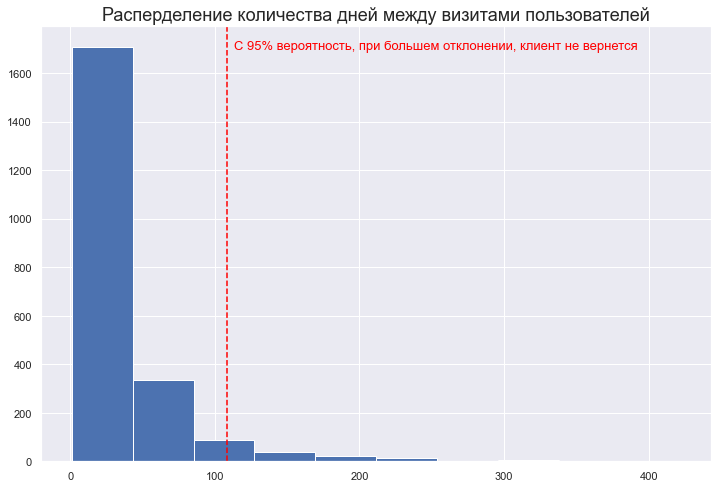

In [171]:
## Построим график и нанесем 95 процентиль клиентов

gap_days.dt.components['days'].hist()
plt.axvline(x=gap_days.dt.components['days'].quantile(0.95),color="red",linestyle="--")
plt.title('Расперделение количества дней между визитами пользователей', fontsize=18)
plt.text(gap_days.dt.components['days'].quantile(0.95)+5, 1700, "С 95% вероятность, при большем отклонении, клиент не вернется", fontsize=13, color = 'red')


In [172]:
## Вычислим 95 процентиль данных 

gap_days.dt.components['days'].quantile(0.95)

108.04999999999973

Text(0.5, 1.0, 'BOXPLOT')

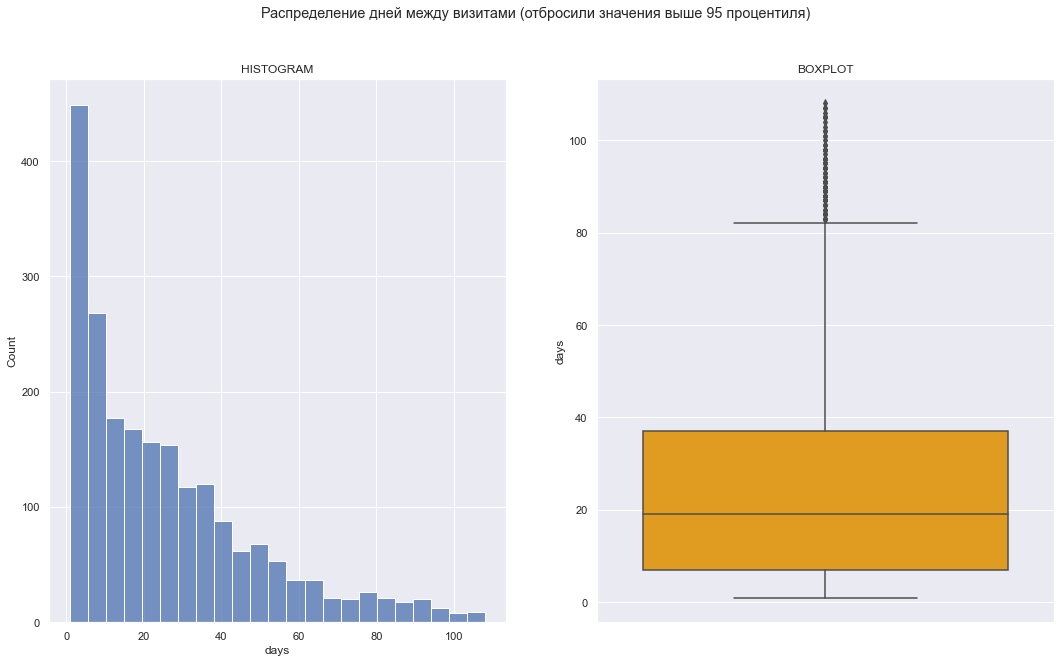

In [173]:
##Рассмотрим данные без аномальных выбросов 

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Распределение дней между визитами (отбросили значения выше 95 процентиля)')


sns.histplot(ax=axes[0], x=gap_days.dt.components['days'][gap_days.dt.components['days'] < gap_days.dt.components['days'].quantile(0.95)])
axes[0].set_title("HISTOGRAM")

sns.boxplot(y = gap_days.dt.components['days'][gap_days.dt.components['days'] < gap_days.dt.components['days'].quantile(0.95)],color = 'orange')
axes[1].set_title("BOXPLOT")

In [174]:
## Определим является ли клиент активным или нет

client_table['D_since_last_visit'] = df['Date'].max() - client_table['last_visit']

client_table['is_away']  = client_table['D_since_last_visit'].dt.components['days']>gap_days.dt.components['days'].quantile(0.95)

client_table.head(10)

,client,first_visit,last_visit,lifetime,sum_visit,unique_tovar,Tovar,visit_by_brand,D_since_last_visit,is_away
0,00001,2021-04-07,2022-02-20,319,15,11,Дегустация цвета короткие,4,36 days,False
1,00002,2021-03-24,2022-02-12,325,25,11,Стрижка мужская,8,44 days,False
2,00007,2021-01-15,2021-01-15,0,2,2,Мелирование очень длинные,1,437 days,True
3,00015,2021-03-22,2021-11-30,253,4,2,"Стрижка кончиков волос (одним срезом, без мыть...",3,118 days,True
4,00030,2021-02-12,2022-02-18,371,20,12,Окрашивание в один цвет коротких волос,7,38 days,False
5,00048,2021-04-09,2021-04-09,0,1,1,Женская стрижка средние с укладкой,1,353 days,True
6,00049,2022-02-27,2022-02-27,0,1,1,Женская стрижка короткие с укладкой,1,29 days,False
7,00062,2022-01-16,2022-01-16,0,1,1,Стрижка мужская,1,71 days,False
8,00081,2021-02-02,2022-02-15,378,11,3,Стрижка мужская,7,41 days,False
9,00090,2021-02-15,2022-03-26,404,3,3,Детская стрижка от 5 до 10 лет,1,2 days,False


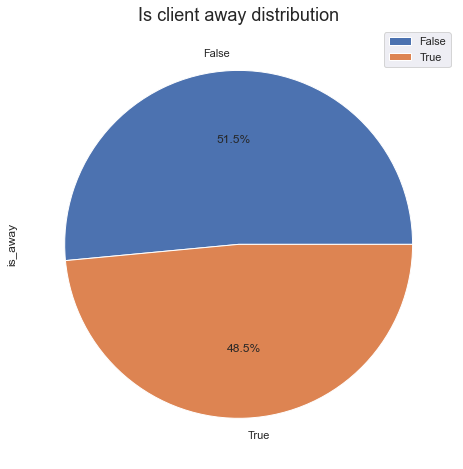

In [175]:
## Визуализируем текущее состояние клиенсткой базы на круговой диаграмме 

plt.figure(figsize=(10,8))

client_table['is_away'].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.legend()
plt.title('Is client away distribution', fontsize=18)
plt.show()

Text(0, 0.5, 'Вероятность выживания')

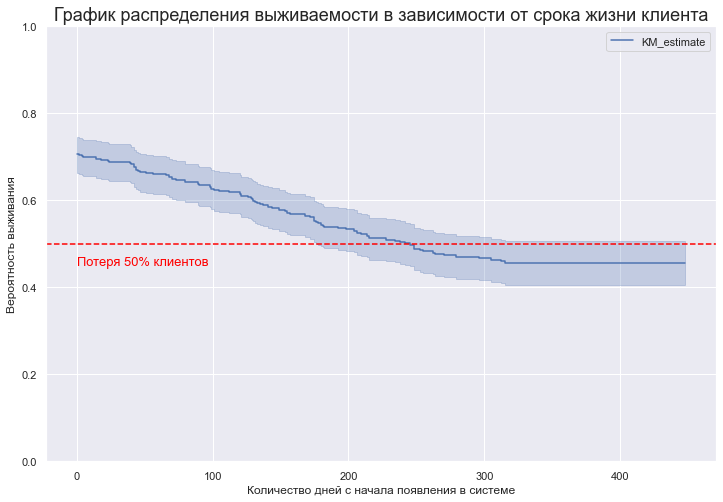

In [176]:
## Построим анализ выживаемости и определим через сколько дней мы теряем 50% клиенсткой базы

import random
from lifelines import KaplanMeierFitter

kmf1 = KaplanMeierFitter()
kmf1.fit(client_table['lifetime'], client_table['is_away'])
ax = kmf1.plot()


ax.set_ylim([0.0, 1.0])

plt.axhline(y=0.5,color="red",linestyle="--")
plt.text(0, 0.45, "Потеря 50% клиентов", fontsize=13, color = 'red')
plt.title('График распределения выживаемости в зависимости от срока жизни клиента', fontsize=18)
plt.xlabel("Количество дней с начала появления в системе")
plt.ylabel("Вероятность выживания")

## Определим 20% лучших клиентов по сроку жизни

In [177]:
## Отделим 80-й процентиль по перемнной lifetime

client_table['lifetime'].quantile(0.80)

359.20000000000005

In [178]:
## Выделим клиентов, которые ходили более 3 раз и живут более 359 (более года) - это и есть наш таргет

client_table[(client_table.sum_visit >3) & (client_table.lifetime>=359)].head(5)

,client,first_visit,last_visit,lifetime,sum_visit,unique_tovar,Tovar,visit_by_brand,D_since_last_visit,is_away
4,00030,2021-02-12,2022-02-18,371,20,12,Окрашивание в один цвет коротких волос,7,38 days,False
8,00081,2021-02-02,2022-02-15,378,11,3,Стрижка мужская,7,41 days,False
18,00154,2021-01-22,2022-03-21,423,43,7,Стрижка мужская,17,7 days,False
30,00414,2021-02-06,2022-03-05,392,20,4,Стрижка коротких волос,7,23 days,False
40,00597,2021-01-04,2022-03-25,445,126,27,Окрашивание корней Redken (до 1 см.),18,3 days,False


In [179]:
## Выделим клиентов, которые ходили более 3 раз, но не дожили до года и считаются ушедшими - это альтернативный вариант развития клиенсткого поведения после 3 покупок 

client_table[(client_table.sum_visit >3) & (client_table.lifetime<359) & (client_table.is_away==True)].head(5)

,client,first_visit,last_visit,lifetime,sum_visit,unique_tovar,Tovar,visit_by_brand,D_since_last_visit,is_away
3,00015,2021-03-22,2021-11-30,253,4,2,"Стрижка кончиков волос (одним срезом, без мыть...",3,118 days,True
11,00097,2021-01-15,2021-11-26,315,21,13,Коррекция бровей,4,122 days,True
12,00099,2021-07-18,2021-07-23,5,6,6,Дегустация цвета средние,1,248 days,True
15,0012124,2021-04-08,2021-08-14,128,4,1,Стрижка мужская,4,226 days,True
25,00233,2021-03-29,2021-10-24,209,6,4,Окрашивание в один цвет коротких волос,2,155 days,True


In [180]:

list_name = np.concatenate((client_table[(client_table.sum_visit >3) & (client_table.lifetime>=359)]['client'],
                client_table[(client_table.sum_visit >3) & (client_table.lifetime<359) & (client_table.is_away==True)]['client']))

In [181]:
group_data = df[df.client.isin(list_name)]

group_data.index = range(0,3036,1)

group_data.head(5)

,datetime,Tovar,client,price,category,Kolichestvo,Date
0,2021-01-15 13:06:33,Женская стрижка средние с укладкой,03533,2300,Укладка,1,2021-01-15
1,2021-01-15 13:06:33,Дегустация цвета короткие,03533,6500,Окрашивание,1,2021-01-15
2,2021-01-15 14:10:19,Женская стрижка средние с укладкой,00097,2300,Укладка,1,2021-01-15
3,2021-01-15 14:10:19,Экспресс-уход Davines (маска в ассорт.),00097,650,Уход,1,2021-01-15
4,2021-01-15 14:42:04,Укладка длинных волос,01906,2500,Укладка,1,2021-01-15


In [182]:
## Выделим первые 3 визита по каждому из рассматриваемых клиентов

client_rank3 = group_data.sort_values(['client','Date']).groupby('client').head(3)

<AxesSubplot:>

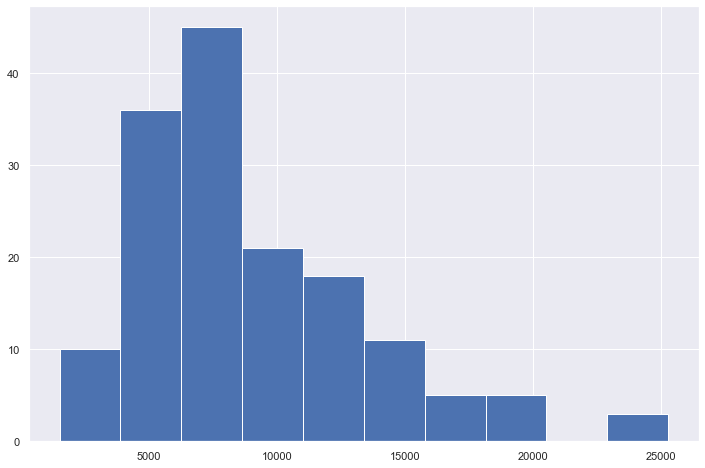

In [183]:
## Распределение выручки за первые 3 визита 

client_rank3.groupby('client').agg(first_visit = ('Date','min'),
                                  last_visit = ('Date','max'),
                                  n_unique_tovar = ('Tovar','nunique'),
                                  Total_sum = ('price','sum'))['Total_sum'].hist()

In [184]:
classdication_data = client_rank3.groupby('client').agg(first_visit = ('Date','min'),
                                  last_visit = ('Date','max'),
                                  n_unique_tovar = ('Tovar','nunique'),
                                  n_unique_category = ('category','nunique'),
                                  Total_sum = ('price','sum'))

classdication_data.head(7)

,first_visit,last_visit,n_unique_tovar,n_unique_category,Total_sum
client,,,,,
00015,2021-03-22,2021-08-17,2,1,4800
00030,2021-02-12,2021-02-12,3,1,13200
00081,2021-02-02,2021-04-15,2,1,5100
00097,2021-01-15,2021-03-05,2,2,5250
00099,2021-07-18,2021-07-18,3,1,11350
0012124,2021-04-08,2021-06-09,1,1,6900
00154,2021-01-22,2021-01-23,3,3,6800


In [185]:
## Определим любимую категорию за первые 3 визита и количество визитов по ней 

lov_tovar_visits = client_rank3.groupby(["client","category"],as_index=False)\
.agg(visit_by_category = ('category','count'))\
.sort_values(['client', 'visit_by_category'], ascending=[True, False]) \
    .groupby('client') \
    .head(1) 

lov_tovar_visits.head(7)

,client,category,visit_by_category
0,00015,Стрижка,3
1,00030,Окрашивание,3
2,00081,Стрижка,3
3,00097,Укладка,2
5,00099,Уход,3
6,0012124,Стрижка,3
7,00154,Окрашивание,1


In [186]:
classdication_data = classdication_data.merge(lov_tovar_visits,on = 'client')

classdication_data.head(7)

,client,first_visit,last_visit,n_unique_tovar,n_unique_category,Total_sum,category,visit_by_category
0,00015,2021-03-22,2021-08-17,2,1,4800,Стрижка,3
1,00030,2021-02-12,2021-02-12,3,1,13200,Окрашивание,3
2,00081,2021-02-02,2021-04-15,2,1,5100,Стрижка,3
3,00097,2021-01-15,2021-03-05,2,2,5250,Укладка,2
4,00099,2021-07-18,2021-07-18,3,1,11350,Уход,3
5,0012124,2021-04-08,2021-06-09,1,1,6900,Стрижка,3
6,00154,2021-01-22,2021-01-23,3,3,6800,Окрашивание,1


<AxesSubplot:xlabel='diff_time', ylabel='Count'>

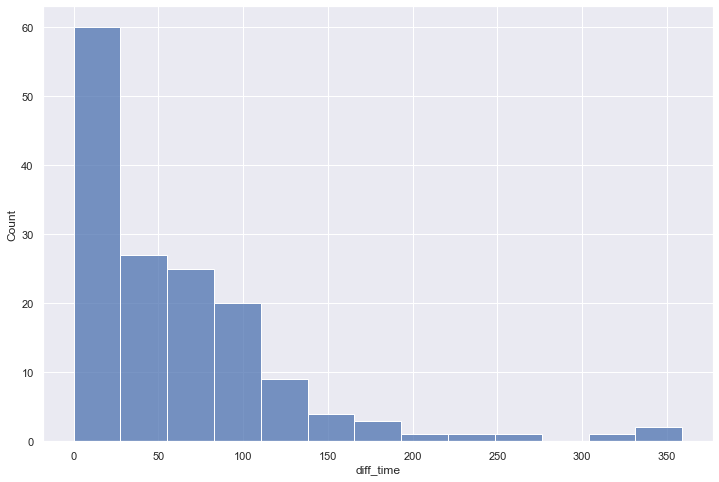

In [187]:
## Определим за какой промежуток дней новый клиент совершил 3 покупки

classdication_data['diff_time'] = (classdication_data.last_visit - classdication_data.first_visit)/np.timedelta64(1,'D')

sns.histplot(x = classdication_data['diff_time'])

In [188]:
## На какую услугу клиент пришел в первый раз

first_tovar = group_data.sort_values(['client','Date']).groupby('client').head(1)

first_tovar = first_tovar[['client','Tovar']]

In [189]:
classdication_data = classdication_data.merge(first_tovar,on = 'client')

In [190]:
classdication_data.head(7)

,client,first_visit,last_visit,n_unique_tovar,n_unique_category,Total_sum,category,visit_by_category,diff_time,Tovar
0,00015,2021-03-22,2021-08-17,2,1,4800,Стрижка,3,148.0,Стрижка длинных волос
1,00030,2021-02-12,2021-02-12,3,1,13200,Окрашивание,3,0.0,Окрашивание в один цвет коротких волос
2,00081,2021-02-02,2021-04-15,2,1,5100,Стрижка,3,72.0,Стрижка мужская
3,00097,2021-01-15,2021-03-05,2,2,5250,Укладка,2,49.0,Женская стрижка средние с укладкой
4,00099,2021-07-18,2021-07-18,3,1,11350,Уход,3,0.0,"Спа уход Абсолютное счастье для волос, длинные..."
5,0012124,2021-04-08,2021-06-09,1,1,6900,Стрижка,3,62.0,Стрижка мужская
6,00154,2021-01-22,2021-01-23,3,3,6800,Окрашивание,1,1.0,Женская стрижка длинные укладкой


## Итог анализа 

•	30% клиентов уходят после первой покупки (70% возвращаются), что говорит о приемлемой степени удержания новых клиентов.   
•	48.1% текущей клиентской базы с вероятностью 95% больше никогда не совершат покупку.  
•	Если человек не появился на протяжение 107 дней, то с вероятностью 95% он больше никогда не будет вашим клиентом.  
•	48.1% текущей клиентской базы с вероятностью 95% больше никогда не совершат покупку   
•	Ваш бизнес теряет 50% активной клиентской базы за месяцев -> стоит запускать новую маркетинговую (рекламную) компанию.



## Классификация пользователей методом ExtraTreesClassifier

In [191]:
## Зададим искомую классификацию через 1/0 по новой переменной Target

classdication_data['Target'] = 0

classdication_data.index = classdication_data.client

classdication_data.loc[client_table[(client_table.sum_visit >3) & (client_table.lifetime>=359)]['client'],"Target"]=1 


In [143]:
## Рассчитаем количество данных каждого типа 

classdication_data['Target'].value_counts()

1    94
0    60
Name: Target, dtype: int64

In [144]:
classdication_data.head(7)

,client,first_visit,last_visit,n_unique_tovar,n_unique_category,Total_sum,category,visit_by_category,diff_time,Tovar,Target
client,,,,,,,,,,,
00015,00015,2021-03-22,2021-08-17,2,1,4800,Стрижка,3,148.0,Стрижка длинных волос,0
00030,00030,2021-02-12,2021-02-12,3,1,13200,Окрашивание,3,0.0,Окрашивание в один цвет коротких волос,1
00081,00081,2021-02-02,2021-04-15,2,1,5100,Стрижка,3,72.0,Стрижка мужская,1
00097,00097,2021-01-15,2021-03-05,2,2,5250,Укладка,2,49.0,Женская стрижка средние с укладкой,0
00099,00099,2021-07-18,2021-07-18,3,1,11350,Уход,3,0.0,"Спа уход Абсолютное счастье для волос, длинные...",0
0012124,0012124,2021-04-08,2021-06-09,1,1,6900,Стрижка,3,62.0,Стрижка мужская,0
00154,00154,2021-01-22,2021-01-23,3,3,6800,Окрашивание,1,1.0,Женская стрижка длинные укладкой,1


In [145]:
## Преобразуем перменную category в тип category,так как все записи на русском языке - будем использовать как фактор

classdication_data['category'] = pd.Categorical(classdication_data['category'])

classdication_data['code_category'] =  classdication_data['category'].cat.codes

classdication_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 00015 to WEB00023
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   client             154 non-null    object  
 1   first_visit        154 non-null    object  
 2   last_visit         154 non-null    object  
 3   n_unique_tovar     154 non-null    int64   
 4   n_unique_category  154 non-null    int64   
 5   Total_sum          154 non-null    int64   
 6   category           154 non-null    category
 7   visit_by_category  154 non-null    int64   
 8   diff_time          154 non-null    float64 
 9   Tovar              154 non-null    object  
 10  Target             154 non-null    int64   
 11  code_category      154 non-null    int8    
dtypes: category(1), float64(1), int64(5), int8(1), object(4)
memory usage: 17.8+ KB


In [146]:
y=classdication_data['Target']
x=classdication_data[['n_unique_category','n_unique_tovar','Total_sum','diff_time','code_category']]

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

## Гиперпараметр: n_estimators

In [147]:
data_score = pd.DataFrame()

for n_estim in range(1,100):
    etc = ExtraTreesClassifier(n_estimators = n_estim) 
    etc.fit(X_train,y_train)
    train_score = etc.score(X_train,y_train)
    test_score = etc.score(X_test,y_test)
    mean_cross_val_score = cross_val_score(etc, X_train,y_train,cv=5).mean()

    pred_data_score = pd.DataFrame({ 'n_estimators':[n_estim],
                               'train_score':[train_score],
                               'test_score':[test_score],
                               'cross_val_score':[mean_cross_val_score]})
                               
    data_score = data_score.append(pred_data_score)

In [150]:
score_data_full = pd.melt(data_score,id_vars = ['n_estimators'], value_vars = ['train_score','test_score','cross_val_score'], var_name = 'set_type', value_name = 'score')

score_data_full

,n_estimators,set_type,score
0,1,train_score,1.000000
1,2,train_score,1.000000
2,3,train_score,1.000000
3,4,train_score,1.000000
4,5,train_score,1.000000
...,...,...,...
292,95,cross_val_score,0.537333
293,96,cross_val_score,0.585667
294,97,cross_val_score,0.521667
295,98,cross_val_score,0.536667


<AxesSubplot:xlabel='n_estimators', ylabel='score'>

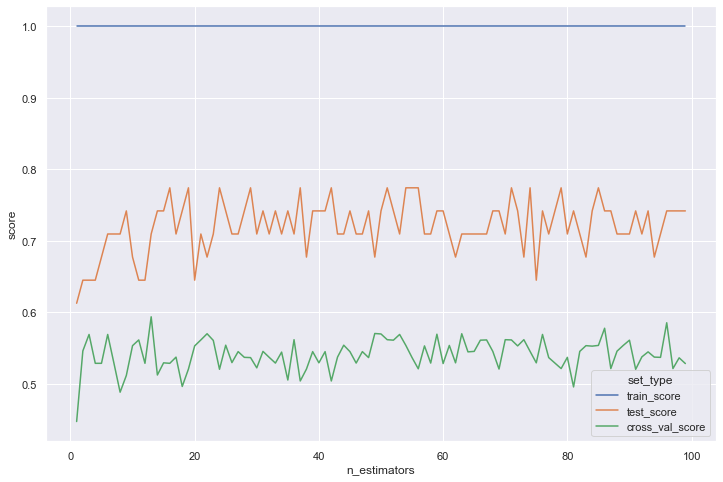

In [151]:
sns.lineplot(x = 'n_estimators', y = 'score',hue = 'set_type',data = score_data_full)

## Гиперпараметр: max_features

<AxesSubplot:xlabel='max_features', ylabel='score'>

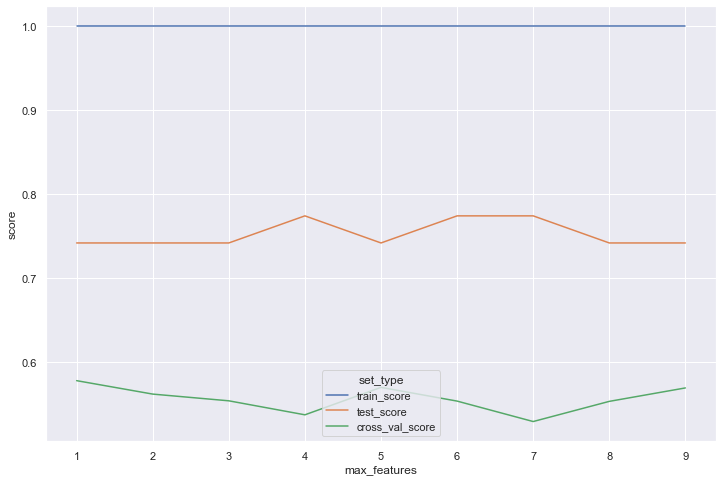

In [152]:
data_score = pd.DataFrame()

for max_feature in range(1,10):
    etc = ExtraTreesClassifier(n_estimators = 50, max_features = max_feature ) 
    etc.fit(X_train,y_train)
    train_score = etc.score(X_train,y_train)
    test_score = etc.score(X_test,y_test)
    mean_cross_val_score = cross_val_score(etc, X_train,y_train,cv=5).mean()

    pred_data_score = pd.DataFrame({ 'max_features':[max_feature],
                               'train_score':[train_score],
                               'test_score':[test_score],
                               'cross_val_score':[mean_cross_val_score]})
                               
    data_score = data_score.append(pred_data_score)
    
    
score_data_full = pd.melt(data_score,id_vars = ['max_features'], value_vars = ['train_score','test_score','cross_val_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x = 'max_features', y = 'score',hue = 'set_type',data = score_data_full)

## Гиперпараметр: min_samples_leaf

<AxesSubplot:xlabel='min_samples_leaf', ylabel='score'>

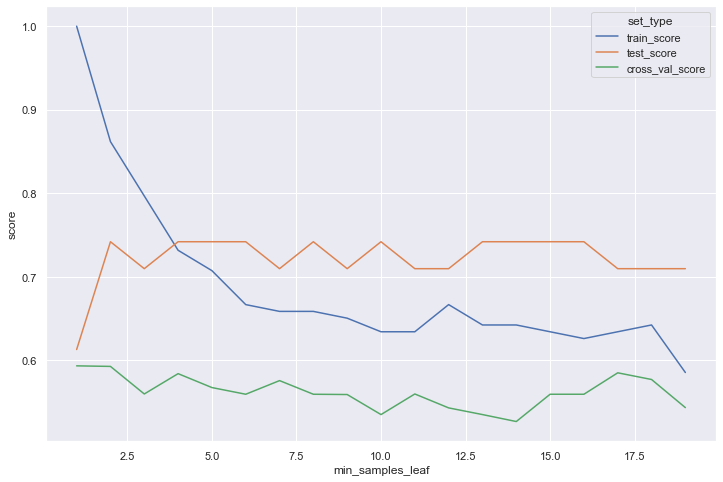

In [87]:
data_score = pd.DataFrame()

for min_leaf in range(1,20):
    etc = ExtraTreesClassifier(n_estimators = 50, max_features = 3, min_samples_leaf = min_leaf) 
    etc.fit(X_train,y_train)
    train_score = etc.score(X_train,y_train)
    test_score = etc.score(X_test,y_test)
    mean_cross_val_score = cross_val_score(etc, X_train,y_train,cv=5).mean()

    pred_data_score = pd.DataFrame({ 'min_samples_leaf':[min_leaf],
                               'train_score':[train_score],
                               'test_score':[test_score],
                               'cross_val_score':[mean_cross_val_score]})
                               
    data_score = data_score.append(pred_data_score)
    
    
score_data_full = pd.melt(data_score,id_vars = ['min_samples_leaf'], value_vars = ['train_score','test_score','cross_val_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x = 'min_samples_leaf', y = 'score',hue = 'set_type',data = score_data_full)

In [200]:
model = ExtraTreesClassifier(n_estimators =30, max_features = 8,min_samples_leaf = 1, min_samples_split = 13)
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid={
        ##'n_estimators': range(10,50,10),
        ##'max_features': range(1,10,1),
        ##'min_samples_leaf': range(1,20,5),
        ##'min_samples_split': range(1,20,2),
        'n_jobs':range(-5,2,1),
        'max_depth': range(1,100,10),
    },
    scoring='r2',
    cv=5
)

grid_result = gsc.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.548056 using {'max_depth': 1, 'n_jobs': -3}


In [205]:
etc = ExtraTreesClassifier(n_estimators=30,max_features=5,min_samples_leaf = 1,min_samples_split=13, max_depth = 50) 
etc.fit(X_train,y_train)

y_pred=etc.predict(X_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",etc.score(X_test,y_test)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.76      0.89      0.82        18

    accuracy                           0.77        31
   macro avg       0.78      0.75      0.76        31
weighted avg       0.78      0.77      0.77        31

Confusion Matrix:
 [[ 8  5]
 [ 2 16]]
Training Score:
 77.41935483870968


<BarContainer object of 5 artists>

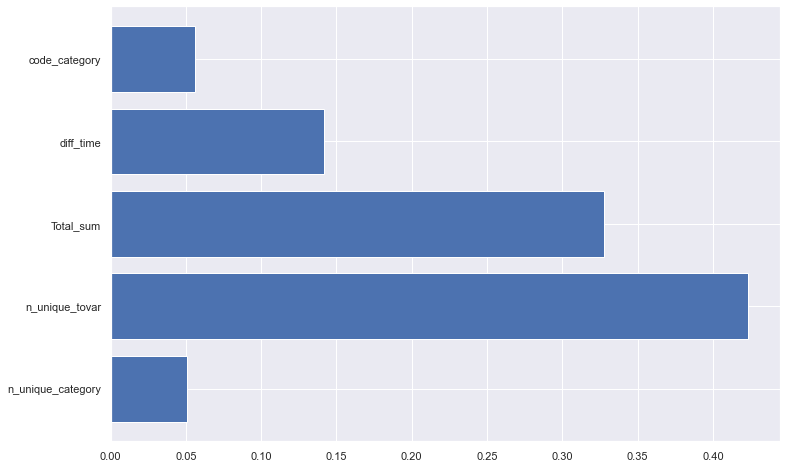

In [215]:
plt.barh(etc.feature_names_in_, etc.feature_importances_)

## Вывод

•	30% клиентов уходят после первой покупки (70% возвращаются), что говорит о приемлемой степени удержания новых клиентов.   
•	48.1% текущей клиентской базы с вероятностью 95% больше никогда не совершат покупку   
•	Если человек не появился на протяжение 107 дней, то с вероятностью 95% он больше никогда не будет вашим клиентом.  
•	48.1% текущей клиентской базы с вероятностью 95% больше никогда не совершат покупку   
•	Ваш бизнес теряет 50% активной клиентской базы за 8 месяцев -> стоит запускать новую маркетинговую (рекламную кампанию) не реже, чем раз в 8 месяцев.   
•	Для каждого клиента сформирован список адресных (персональных) товарных рекомендаций   
•	Модель предсказания клиентского поведения по 3 первым покупкам работает с вероятностью 75-77%  


